# Week 4: NLP Disaster Tweets Kaggle Mini-Project

This challenge is about building a machine learning model that predicts which Tweets are about real disasters and which ones aren’t, where our dataset is composed of 10,000 tweets that were hand classified.
To approach this problem, it will be performed a basic exploratory analysis of the training data, to observe general characteristics, such as size, structure, and proportions, then a brief preprocessing of the data using NLP techniques, and finally the proposal of a model of RNN.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gensim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


In [3]:
training_data_path = 'D:/PythonCourse/DisasterTweets/data/train.csv'
train_data = pd.read_csv(training_data_path) # Read data from csv file
train_data.head() # View data head to get familiar with the columns

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


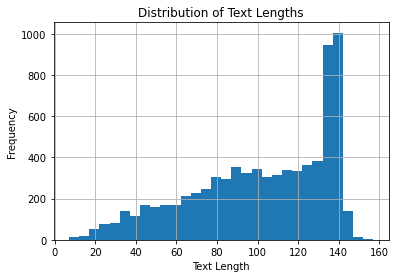

In [34]:
train_data['text_length'] = train_data['text'].apply(len)
train_data['text_length'].hist(bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


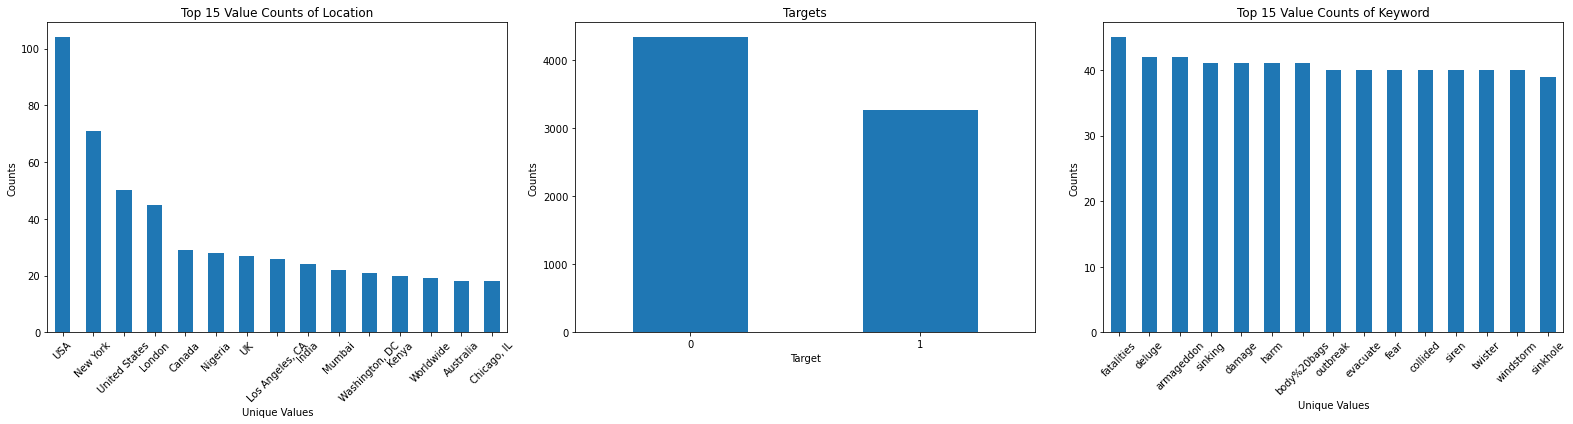

In [35]:

# Create a figure with 1 row and 3 columns (for 3 plots side by side)
fig, axes = plt.subplots(1, 3, figsize=(22, 6)) 

# First plot (location count)
location_count = train_data['location'].value_counts().head(15)
location_count.plot(kind='bar', ax=axes[0])  # Specify which subplot to plot in
axes[0].set_title('Top 15 Value Counts of Location')
axes[0].set_xlabel('Unique Values')
axes[0].set_ylabel('Counts')
axes[0].tick_params(axis='x', rotation=45)

# Second plot (target count)
target_count = train_data['target'].value_counts()
target_count.plot(kind='bar', ax=axes[1])
axes[1].set_title('Targets')
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Counts')
axes[1].tick_params(axis='x', rotation=0)

# Third plot (keyword count)
kw_count = train_data['keyword'].value_counts().head(15)
kw_count.plot(kind='bar', ax=axes[2])
axes[2].set_title('Top 15 Value Counts of Keyword')
axes[2].set_xlabel('Unique Values')
axes[2].set_ylabel('Counts')
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


## Word Embedding 
To convert the string of text to a format compatible with the structure of Neural Networks, we can use some techniques that encode meaning of words to a vectorial representation useful for this NLP task.
The first one we'll explore is Word2Vec. The goal of Word2Vec is to represent words as vectors (lists of numbers), where words that have similar meanings or are used in similar contexts end up having similar vectors. For example, "king" and "queen" will have vectors that are close to each other, while "king" and "apple" will be far apart because they have very different meanings.

In [4]:
from transformers import BertTokenizer, BertModel
import torch

# Load pretrained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize the text and get input_ids and attention masks
def tokenize_tweets(tweets, max_len=128):
    return tokenizer(tweets, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')

# Tokenize the tweets
tokenized_tweets = tokenize_tweets(train_data['text'].tolist())
input_ids = tokenized_tweets['input_ids']
attention_masks = tokenized_tweets['attention_mask']


## Architectures (LSTM/GRU)
This architecture combines a pre-trained BERT model with a Recurrent Neural Network (RNN) to classify disaster-related tweets. BERT is used to generate contextualized embeddings of the input text, capturing semantic information from the tweet. These embeddings are then fed into an RNN, either an LSTM or GRU, which processes the sequence of embeddings and captures temporal dependencies. The model uses the hidden state from the last time step of the RNN as a summary of the tweet's content. This hidden state is passed through a fully connected layer, followed by a sigmoid activation, to produce a binary classification output (disaster or not). The BERT model's parameters are frozen to leverage its pre-trained knowledge without further training, while the RNN learns to detect patterns relevant to disaster tweets.

In [5]:
class BERT_RNN_Classifier(nn.Module):
    def __init__(self, bert_model, rnn_type='LSTM', hidden_dim=128, output_dim=1):
        super(BERT_RNN_Classifier, self).__init__()
        
        self.bert = bert_model
        self.hidden_dim = hidden_dim
        
        # Freeze the BERT parameters (optional, fine-tuning would otherwise happen)
        for param in self.bert.parameters():
            param.requires_grad = False

        # Define RNN (LSTM or GRU)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=768, hidden_size=hidden_dim, batch_first=True)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Sigmoid for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        with torch.no_grad():  # Optional: don't update BERT weights
            outputs = self.bert(input_ids, attention_mask=attention_mask)
        
        # BERT embeddings (batch_size, sequence_length, 768)
        embeddings = outputs.last_hidden_state

        # Feed BERT embeddings into RNN
        rnn_output, _ = self.rnn(embeddings)
        
        # Use the final hidden state for classification
        final_output = rnn_output[:, -1, :]
        
        # Fully connected layer
        output = self.fc(final_output)
        
        # Sigmoid activation for binary classification
        return self.sigmoid(output)


In [6]:
from torch.utils.data import DataLoader, TensorDataset

# Convert inputs and labels to PyTorch tensors
labels = torch.tensor(train_data['target'].values)

# Create a dataset and data loader
dataset = TensorDataset(input_ids, attention_masks, labels)
batch_size = 16
train_dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)


## Training
For the hyperparameter tuning, there are tested 2 approaches, that consist of using a regular learning rate and observe how the loss changes as the learning rate increases and a plot to compare the behaviors.

In [71]:
import torch.optim as optim
import torch.nn as nn
import random
def train(rn_type, training_lr, epochs):
    print('Traning model', rn_type, ' learning rate: ',training_lr)
    model_loss = []
    #Instantiate the model
    model = BERT_RNN_Classifier(bert_model, rnn_type=rn_type, hidden_dim=128, output_dim=1)
    
    # Define loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=training_lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        
        total_loss = 0
        count=0
        for step, batch in enumerate(train_dataloader):
            batch_input_ids, batch_attention_mask, batch_labels = batch
            
            # Forward pass
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            loss = criterion(outputs.squeeze(), batch_labels.float())
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            #Added a count to reduce the training time, only for debugging
            if count>100: 
                break
            else:
                count+=1
        
        avg_loss = total_loss / len(train_dataloader)
        model_loss.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    
    model_name = 'RNN_'+rn_type+'_'+str(training_lr).replace('.','-')+'.pth'
    try:
        torch.save(model.state_dict(), model_name)
        print(model_name, ' was saved.')
    except:
        print('Error saving ',model_name) 
    
    return model_loss


In [40]:
model_losses = []
learning_rates = [2e-5, 1e-4]  # Test a few learning rates to test the training loop
for lr in learning_rates:
    curr_loss = train(rn_type='LSTM', training_lr=lr, epochs=2)
    model_losses.append(curr_loss)
print(model_losses)  

Epoch 1/2, Loss: 0.6485
Epoch 2/2, Loss: 0.5460
RNN_LSTM2e-05.pth  was saved.
Epoch 1/2, Loss: 0.5488
Epoch 2/2, Loss: 0.4750
RNN_LSTM0.0001.pth  was saved.
[[0.6485332545487821, 0.5459850647118913], [0.5488309926596009, 0.47498251400700137]]


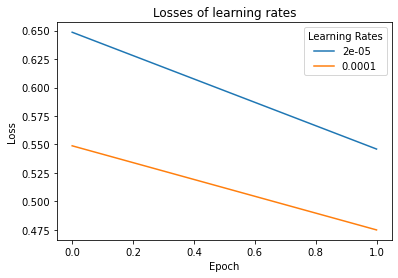

In [52]:
import matplotlib.pyplot as plt # Imports
for i, model_loss in enumerate(model_losses):
    epochs = list(range(len(model_loss)))
    plt.plot(epochs, model_loss, label= learning_rates[i]) #plot the losses of the previous models
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses of learning rates')
plt.legend(title="Learning Rates")
plt.show()


## Hyper Parameter tuning

It is performed a series of trainings for the learning rate tuning in the two architectures explored, the losses are stored and later compared in a plot to better visualize the behaviors and impact of the values selected for the tuning.

In [72]:
model_losses = []
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]
rn_types = ['LSTM', 'GRU']
model_name = []
for rn_neuron in rn_types:
    for lr in learning_rates:
        print('Building model: ', rn_neuron, 'and lr: ', lr)  
        curr_loss = train(rn_type=rn_neuron, training_lr=lr, epochs=5)
        model_losses.append(curr_loss)
        model_name.append(rn_neuron+str(lr).replace('.','-'))


Building model:  LSTM and lr:  1e-05
Traning model LSTM  learning rate:  1e-05
Epoch 1/5, Loss: 0.1452
Epoch 2/5, Loss: 0.1431
Epoch 3/5, Loss: 0.1398
Epoch 4/5, Loss: 0.1377
Epoch 5/5, Loss: 0.1361
RNN_LSTM_1e-05.pth  was saved.
Building model:  LSTM and lr:  5e-05
Traning model LSTM  learning rate:  5e-05
Epoch 1/5, Loss: 0.1427
Epoch 2/5, Loss: 0.1325
Epoch 3/5, Loss: 0.1230
Epoch 4/5, Loss: 0.1094
Epoch 5/5, Loss: 0.1059
RNN_LSTM_5e-05.pth  was saved.
Building model:  LSTM and lr:  0.0001
Traning model LSTM  learning rate:  0.0001
Epoch 1/5, Loss: 0.1361
Epoch 2/5, Loss: 0.1160
Epoch 3/5, Loss: 0.1056
Epoch 4/5, Loss: 0.1043
Epoch 5/5, Loss: 0.1062
RNN_LSTM_0-0001.pth  was saved.
Building model:  LSTM and lr:  0.0005
Traning model LSTM  learning rate:  0.0005
Epoch 1/5, Loss: 0.1251
Epoch 2/5, Loss: 0.1097
Epoch 3/5, Loss: 0.1072
Epoch 4/5, Loss: 0.1048
Epoch 5/5, Loss: 0.1082
RNN_LSTM_0-0005.pth  was saved.
Building model:  LSTM and lr:  0.001
Traning model LSTM  learning rate:  0

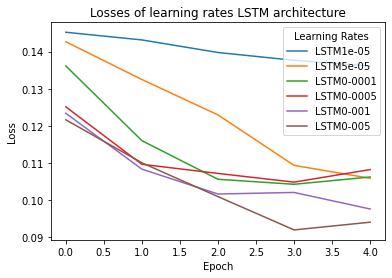

In [77]:
for i, model_loss in enumerate(model_losses):
    epochs = list(range(len(model_loss)))
    if 'LSTM' in model_name[i]:
        plt.plot(epochs, model_loss, label= model_name[i]) #plot the losses of the previous models
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses of learning rates LSTM architecture')
plt.legend(title="Learning Rates")
plt.show()


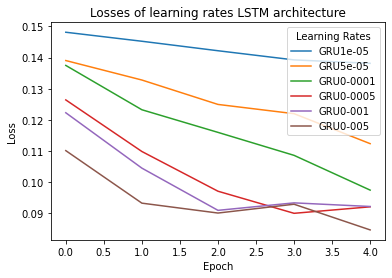

In [78]:
for i, model_loss in enumerate(model_losses):
    epochs = list(range(len(model_loss)))
    if 'GRU' in model_name[i]:
        plt.plot(epochs, model_loss, label= model_name[i]) #plot the losses of the previous models
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses of learning rates GRU architecture')
plt.legend(title="Learning Rates")
plt.show()

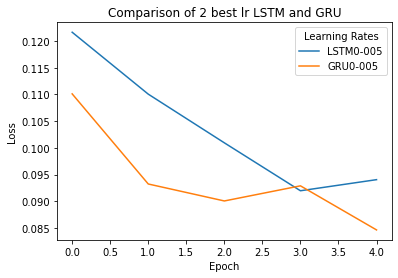

In [79]:
for i, model_loss in enumerate(model_losses):
    epochs = list(range(len(model_loss)))
    if 'LSTM0-005' in model_name[i] or 'GRU0-005' in model_name[i]:
        plt.plot(epochs, model_loss, label= model_name[i]) #plot the losses of the previous models
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of 2 best lr LSTM and GRU')
plt.legend(title="Learning Rates")
plt.show()

## Conclusion 

Initially, the GRU model shows a faster reduction in loss compared to the LSTM. By the end of the 4th epoch, GRU achieves a lower loss value, indicating better performance in this task within the first few epochs. The LSTM's performance stabilizes after the 3rd epoch, while the GRU continues to improve, suggesting that GRU may be more efficient with this learning rate and dataset.
The difference in performance between the LSTM and GRU models could be attributed to the architectural differences between the two. Here are some possible reasons:

-Simplicity of GRU: GRU is generally simpler than LSTM, having fewer gates (reset and update gates) compared to LSTM’s three (input, forget, and output gates). This makes GRUs less complex and faster to train, which might explain why GRU is reducing loss more rapidly in the early epochs.

-Overhead in LSTM: LSTMs, with their more complex gating mechanisms, may require more epochs to reach their full potential. The additional gates can help LSTMs capture longer-term dependencies in data, but it may take longer for the network to adjust and show improvements in the early stages of training.

-Task-Specific Efficiency: For certain tasks, especially if the data contains shorter-term dependencies, GRUs might perform better because they are less prone to overfitting and may generalize better in fewer epochs. If the disaster tweet classification task primarily involves capturing shorter-term dependencies, GRU might be more suited to this task.

-Learning Rate Sensitivity: While both models use the same learning rate (0.005), GRU might be responding better to this rate due to its simpler structure. LSTMs might benefit from either a smaller or larger learning rate to fully leverage their architecture and could need more fine-tuning to show better results over time.

In summary, the GRU's simpler design might make it faster and more efficient in learning patterns in the data with fewer epochs, whereas LSTM might need more epochs to show comparable or better performance, especially for tasks requiring more complex temporal dependencies
Discussion of learning and takeaways

### Suggestions for ways to improve
It can be explored a deeper network with more layers to see if it enhances the prediction capabilities, another suggestion includes testing on a validation subset, a simpler word embbeding, the inclusion of the other predictors such as location.
Enhancing the preprocessing of the data, such as removing urls, and other features might be beneficial.

In [125]:
model_test.eval()  # Set the model to evaluation mode 

# Initialize lists to store input IDs and predictions
train_predictions = []

with torch.no_grad():
    for batch in tqdm(train_dataloader, desc="Processing batches", unit="batch"):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        # Forward pass
        outputs = model_test(batch_input_ids, attention_mask=batch_attention_mask)
        # Get binary predictions (assuming binary classification, adjust as needed)
        predictions = torch.round(outputs.squeeze())  # Round to get binary predictions

        # Append the input IDs and predictions to the lists
        train_predictions.extend(predictions.cpu().numpy())    # Move to CPU and convert to numpy

Processing batches: 100%|█████████████████████████████████████████████████████████| 476/476 [11:47<00:00,  1.49s/batch]


In [8]:
# def calculate_acc(labels, pred):
#     equal_count = sum(1 for a, b in zip(labels, pred) if a == b)
#     # Calculate the percentage of equal elements
#     return (equal_count / len(labels)) * 100
# labels = train_data['target'].tolist()
# acc_train = calculate_acc(labels, train_predictions)
# print(acc_train)

In [9]:
test_data_path = 'D:/PythonCourse/DisasterTweets/data/test.csv'
test_data = pd.read_csv(test_data_path) # Read data from csv file


In [10]:
tokenized_tweets_test = tokenize_tweets(test_data['text'].tolist())
input_ids_test = tokenized_tweets_test['input_ids']
attention_masks_test = tokenized_tweets_test['attention_mask']

In [11]:
dataset_test = TensorDataset(input_ids_test, attention_masks_test)
batch_size = 16
test_dataloader = DataLoader(dataset_test, shuffle=False, batch_size=batch_size)

In [104]:
model_test = BERT_RNN_Classifier(bert_model, rnn_type='GRU', hidden_dim=128, output_dim=1)
model_test.load_state_dict(torch.load('RNN_GRU_0-005.pth'))  # Replace with your model's path

<All keys matched successfully>

In [120]:
from tqdm import tqdm

model_test.eval()  # Set the model to evaluation mode 

# Initialize lists to store input IDs and predictions
all_predictions = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Processing batches", unit="batch"):
        batch_input_ids, batch_attention_masks = batch
        # Forward pass
        outputs = model_test(batch_input_ids, attention_mask=batch_attention_masks)
        # Get binary predictions (assuming binary classification, adjust as needed)
        predictions = torch.round(outputs.squeeze())  # Round to get binary predictions

        # Append the input IDs and predictions to the lists
        all_predictions.extend(predictions.cpu().numpy())    # Move to CPU and convert to numpy
       
  


Processing batches: 100%|█████████████████████████████████████████████████████████| 204/204 [05:08<00:00,  1.51s/batch]


In [144]:
input_id = test_data['id'].tolist()
all_predictions = [int(pred) for pred in all_predictions]
# Create a pandas DataFrame with input IDs and predictions
df_results = pd.DataFrame({
    'id': input_id,  # Store input IDs
    'target': all_predictions  # Store predictions
})

# Optionally, save the DataFrame to a CSV file
df_results.to_csv('predictions.csv', index=False)


## Final Training


In [16]:
import torch.optim as optim
import torch.nn as nn
import random
from tqdm import tqdm

#Instantiate the model
model = BERT_RNN_Classifier(bert_model, rnn_type='GRU', hidden_dim=128, output_dim=1)
model.load_state_dict(torch.load('Final_RNN_model.pth'))   
# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc="Processing batches", unit="batch"):
        batch_input_ids, batch_attention_mask, batch_labels = batch
        
        # Forward pass
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        loss = criterion(outputs.squeeze(), batch_labels.float())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}/{5}, Loss: {avg_loss:.4f}')

model_name = 'Final_RNN_model2'+'.pth'
try:
    torch.save(model.state_dict(), model_name)
    print(model_name, ' was saved.')
except:
    print('Error saving ',model_name) 


Processing batches: 100%|█████████████████████████████████████████████████████████| 476/476 [13:51<00:00,  1.75s/batch]


Epoch 1/5, Loss: 0.3536


Processing batches: 100%|█████████████████████████████████████████████████████████| 476/476 [14:05<00:00,  1.78s/batch]


Epoch 2/5, Loss: 0.3465


Processing batches: 100%|█████████████████████████████████████████████████████████| 476/476 [13:42<00:00,  1.73s/batch]


Epoch 3/5, Loss: 0.3463


Processing batches: 100%|█████████████████████████████████████████████████████████| 476/476 [16:27<00:00,  2.07s/batch]


Epoch 4/5, Loss: 0.3410


Processing batches: 100%|█████████████████████████████████████████████████████████| 476/476 [20:05<00:00,  2.53s/batch]


Epoch 5/5, Loss: 0.3406
Final_RNN_model2.pth  was saved.


In [17]:
model_testf = BERT_RNN_Classifier(bert_model, rnn_type='GRU', hidden_dim=128, output_dim=1)
model_testf.load_state_dict(torch.load('Final_RNN_model2.pth'))   

# Initialize lists to store input IDs and predictions
all_predictions = []

with torch.no_grad():
    model.train()
    for batch in tqdm(test_dataloader, desc="Processing batches", unit="batch"):
        batch_input_ids, batch_attention_masks = batch
        # Forward pass
        outputs = model_testf(batch_input_ids, attention_mask=batch_attention_masks)
        # Get binary predictions (assuming binary classification, adjust as needed)
        predictions = torch.round(outputs.squeeze())  # Round to get binary predictions

        # Append the input IDs and predictions to the lists
        all_predictions.extend(predictions.cpu().numpy())    # Move to CPU and convert to numpy
        
input_id = test_data['id'].tolist()
all_predictions = [int(pred) for pred in all_predictions]
# Create a pandas DataFrame with input IDs and predictions
df_results = pd.DataFrame({
    'id': input_id,  # Store input IDs
    'target': all_predictions  # Store predictions
})

# Optionally, save the DataFrame to a CSV file
df_results.to_csv('predictions3.csv', index=False)


Processing batches: 100%|█████████████████████████████████████████████████████████| 204/204 [08:23<00:00,  2.47s/batch]


#### References
Word2Vec https://en.wikipedia.org/wiki/Word2vec#:~:text=Word2vec%20is%20a%20technique%20in,text%20in%20a%20large%20corpus.
NLP tutorial https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial